# Download model variables

Download as raster layers covering your study area envelope, including:

- At least one **soil** variable from the [POLARIS dataset](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/) (**find thresholds**)
    - [POLARIS: 30-meter probabilistic soil series map of contiguous US](https://pubs.usgs.gov/publication/70170912)
    - <https://scholars.duke.edu/publication/1381493>
    - <https://gee-community-catalog.org/projects/polaris/>
    - NW Chaney et al. (2019) POLARIS Soil Properties: 30-m Probabilistic Maps of Soil Properties Over the Contiguous United States. [DOI: 10.1029/2018WR022797](https://doi.org/10.1029/2018WR022797)
    - Elsa Culler EarthLab Videos
        - [Accessing and formatting URLS for POLARIS data](https://cuboulder.zoom.us/rec/share/imhCGJcrCgSoE1cJjg02r86GMNjiRz0jwVMJ5c0uWNwBCD5D_0kLSl3CaqLdDI2a.ucGta1EEAiirDUop)
        - [Looping through multiple tiles of POLARIS data](https://cuboulder.zoom.us/rec/share/3S7pGOSv7jztZTvg4RSXLj-GicnHwusIDIEDoETZbUN7ivkc6Ryi5GAJyX9Ly6h2.VXl6iFmLChjjUyOg)
- Elevation from the SRTM (available from the [earthaccess API](https://github.com/nsidc/earthaccess/))
- At least one **climate** variable from the [MACAv2 THREDDS data server](http://thredds.northwestknowledge.net:8080/thredds/reacch_climate_CMIP5_macav2_catalog2.html).
    - Pick 2 of these
    - [GeoNetwork](https://docs.geonetwork-opensource.org/4.2/):
[THREDDS Harvesting](https://docs.geonetwork-opensource.org/4.2/user-guide/harvesting/harvesting-thredds/)

## POLARIS Dataset

Considering `sand` percentage `mean`. POLARIS data are available at 6 depths, and Bluestem has roots down to 5 feet (150 cm), which is the lowest strata measured (100-200 cm). Data in the
[sand 100-200 cm directory](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/)
are saved as separate tif files by longitude.
Buvvalo Gap National Grassland is at (centroid) 43.4375° N, 103.0505° W, while Oglala National Grassland is at 42.9404° N, 103.5900° W. That probably suggests

- [lat4344_lon-103-102.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-103-102.tif) (33M)
- [lat4344_lon-104-103.tif](http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-104-103.tif) (33M)

In [1]:
import os
import pathlib
#from math import floor ceil

import geopandas as gpd
import rioxarray as rxr

In [2]:
pip install ../envsys

Processing /Users/brianyandell/Documents/GitHub/envsys
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for envsys: filename=envsys-0.1-py3-none-any.whl size=15421 sha256=557149407f00b2a87b4af22d27c27706009c1ab0b577c33c882acdd1bb31c488
  Stored in directory: /private/var/folders/tt/cyd1sy9s18l1fgc_0ty8l91w0000gn/T/pip-ephem-wheel-cache-69lac9jv/wheels/5d/85/f4/a91a3ba267016276379c270f371c3bb435230a32e6a1b5f5ad
Successfully built envsys
  Attempting uninstall: envsys
    Found existing installation: envsys 0.1
    Uninstalling envsys-0.1:
      Successfully uninstalled envsys-0.1
Note: you may need to restart the kernel to use updated packages.


### Single POLARIS TIFF

In [18]:
soil_url = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "sand/"
    "mean/"
    "100_200/"
    "lat4344_lon-104-103.tif"
)
soil_url

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-104-103.tif'

In [24]:
soil_da = rxr.open_rasterio(
    soil_url,
    mask_and_scale=True
).squeeze()
soil_da

<xarray.DataArray (y: 3600, x: 3600)> Size: 52MB
[12960000 values with dtype=float32]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 29kB -104.0 -104.0 -104.0 ... -103.0 -103.0 -103.0
  * y            (y) float64 29kB 44.0 44.0 44.0 44.0 ... 43.0 43.0 43.0 43.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area

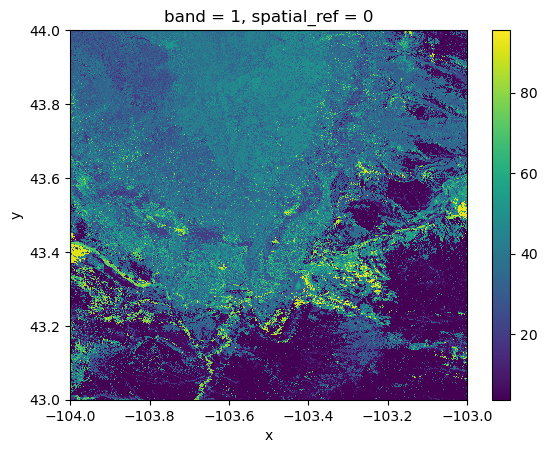

In [8]:
soil_da.plot()

### Multiple POLARIS TIFFs

Get boundary for study. Fake Denver for now.
Determine `lat` and `lon` based on site.
Set up `for` loop.

In [ ]:
denver_path = os.path.join(
    pathlib.Path.home(),
    "earth-analytics",
    "data",
    "denver-air-quality",
    "denver-boundary",
    "denver.shp"
)
denver_gdf = gpd.read_file(denver_path)
denver_gdf.plot()

In [25]:
soil_url_template = (
    "http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/"
    "sand/"
    "mean/"
    "100_200/"
    "lat{min_lat}{max_lat}_lon{min_lon}{max_lon}.tif"
)
soil_url_template.format(min_lat = 43, max_lat = 44, min_lon = -103, max_lon = -104)

'http://hydrology.cee.duke.edu/POLARIS/PROPERTIES/v1.0/sand/mean/100_200/lat4344_lon-103-104.tif'

In [ ]:
bounds_min_lon, bounds_min_lat, bounds_max_lon, bounds_max_lat = (
    denver_gdf.total_bounds)

soil_url_list = []
for min_lon in range(floor(bounds_min_lon), ceil(bounds_max_lon)):
    for min_lat in range(floor(bounds_min_lat), ceil(bounds_max_lat)):
        print(min_lon, min_lat)
        soil_url = soil_url_template.format(min_lat = min_lat, max_lat = min_lat + 1,
                                             min_lon = min_lon, max_lon = min_lon + 1)
        soil_url_list.append(soil_url)

can download in list and merge as before (see redlining `merge_das`)

## Test My Package `envsys`

Somehow only part of the library is getting installed. Needs more work?

In [16]:
dir(envsys)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'fibo',
 'process_image']

In [15]:
import envsys
envsys.example.mod_name()

AttributeError: module 'envsys' has no attribute 'example'

In [6]:
from envsys.example import mod_name
mod_name()

envsys.example


In [1]:
from envsys import fibo
fibo.fib(100)

0 1 1 2 3 5 8 13 21 34 55 89 


We now have `process_image` and `process_cloud_mask` as part of package `envsys`.

In [3]:
from envsys import process_image
process_image

<module 'envsys.process_image' from '/Users/brianyandell/miniconda3/envs/earth-analytics-python/lib/python3.11/site-packages/envsys/process_image.py'>